# Import

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os

# Dataset

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

#map input to (-1,+1) for better training
x_train,x_test = x_train/255.0 * 2 - 1, x_test/255.0 * 2 - 1

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
# Flatten data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1,D)
x_test = x_test.reshape(-1,D)

In [ ]:
#Dimensionality of latent space
latent_dim = 100

# Models

## Generator

In [ ]:
# Get generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation='tanh')(x) #because our data is in between (-1, +1)

    model = Model(i,x)
    return model
    

## Discriminator

In [ ]:
# Get discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model =Model(i,x)
    return model

In [ ]:
# compile both models

discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))#create an input to represent noise sample from latent space
img = generator(z) # pass noise to get an image

discriminator.trainable = False # make sure only generator is trained

fake_pred = discriminator(img) # true output is fake but we label them real

combined_model = Model(z,fake_pred) # combined model object
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

## Train the GAN

In [ ]:
# config
batch_size = 32
epochs = 30000
sample_period = 200 # every sample_period steps generate and save some data

# create batch labels to use when calling train_on_batch
ones= np.ones(batch_size) #because we have same labels , it would be best to create them before we start training
                          # and not have to instancate new objects later on inside loop
zeros = np.zeros(batch_size)

#store the losses
d_losses = []
g_losses = []

# Create folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
ones, len(zeros)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 32)

In [ ]:
# A function to generate a grid of random samples from
# the generator and save them to a file
def sample_images(epoch):
    rows,cols =5,5
    noise = np.random.randn(rows* cols, latent_dim) #Number of samples x Number of dimensions (25 x 100) 
    imgs = generator.predict(noise) #gives 25 generated samples

    #rescale image 0-1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols) #creates a new figure object and returns a tuple containing a Figure object and an array of Axes objects.
    idx = 0
    for i in range(rows):
      for j in range(cols):
        axs[i,j].imshow(imgs[idx].reshape(H,W), cmap='gray')
        axs[i,j].axis('off') # lines are removed
        idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()



In [ ]:
# Main training loop
for epoch in range(epochs):
   ###########################
   #####Train Discriminator###
   ###########################

   # select random batch of real image
   idx = np.random.randint(0, x_train.shape[0], batch_size)
   real_imgs = x_train[idx]

   # Generate fake images
   noise = np.random.randn(batch_size, latent_dim)
   fake_imgs = generator.predict(noise)

   #Train the discriminator
   d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones) #label ones given to real image
   d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros) # label zeros given to fake image
   d_loss = 0.5 *(d_loss_real+d_loss_fake)
   d_acc = 0.5 * (d_acc_real + d_acc_fake)

   ###########################
   #####Train Generator ######
   ###########################
   noise = np.random.randn(batch_size, latent_dim)
   g_loss = combined_model.train_on_batch(noise, ones) # Tricking discriminator

   # save the losses
   d_losses.append(d_loss)
   g_losses.append(g_loss)

   if epoch % 100 == 0:
     print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f},\
     d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
   if epoch % sample_period == 0: #every 200 sample_period : generate some samples and save
     sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
epoch: 25101/30000, d_loss: 0.63,     d_acc: 0.73, g_loss: 0.95
1/1 [==============================] - 0s 27ms/step
epoch: 25201/30000, d_loss: 0.64,     d_acc: 0.67, g_loss: 1.03
1/1 [==============================] - 0s 41ms/step
epoch: 25301/30000, d_loss: 0.57,     d_acc: 0.80, g_loss: 1.02
1/1 [==============================] - 0s 25ms/step
epoch: 25401/30000, d_loss: 0.59,     d_acc: 0.64, g_loss: 1.10
1/1 [==============================] - 0s 36ms/step
epoch: 25501/30000, d_loss: 0.65,     d_acc: 0.52, g_loss: 1.06
1/1 [==============================] - 0s 25ms/step
epoch: 25601/30000, d_loss: 0.63,     d_acc: 0.69, g_loss: 1.02
1/1 [==============================] - 0s 27ms/step
epoch: 25701/30000, d_loss: 0.64,     d_acc: 0.64, g_loss: 0.95
1/1 [==============================] - 0s 47ms/step
epoch: 25801/30000, d_loss: 0.68,     d_acc: 0.53, g_loss: 1.06
1/1 [================

conclusion: dispite we train discriminator, it never reaches high accuracy. Because both discriminator and generator are improving

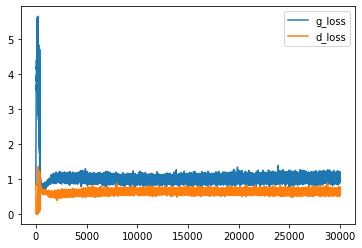

In [ ]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend()

In [ ]:
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

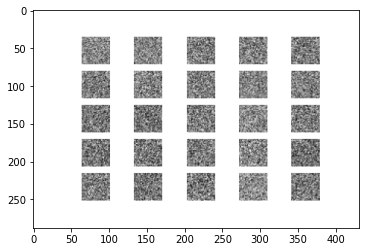

In [ ]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

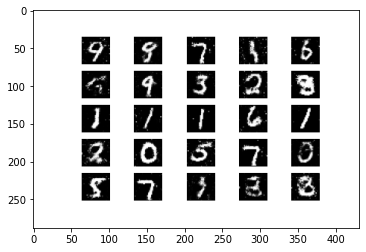

In [ ]:
from skimage.io import imread
a = imread('gan_images/10000.png')
plt.imshow(a)

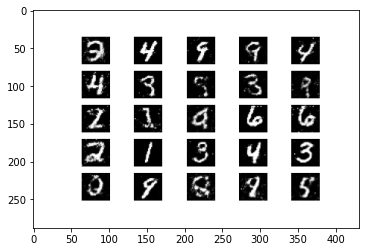

In [ ]:
from skimage.io import imread
a = imread('gan_images/20000.png')
plt.imshow(a)

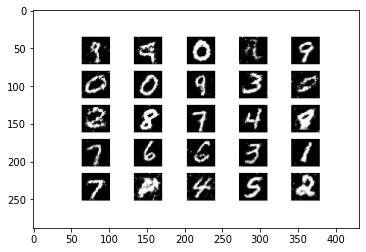

In [ ]:
from skimage.io import imread
a = imread('gan_images/29800.png')
plt.imshow(a)

Generators learns to generate real looking images quickly